In [12]:
import numpy as np, pandas as pd, random
from datetime import datetime, timedelta
from scipy.stats import norm, lognorm, pareto

np.random.seed(42); random.seed(42)

######################## 1. PERFORMANCE_TB ########################
n = 100_000
perf_id   = np.arange(1001, 1001+n)
perf_name = [f"공연_{i}" for i in perf_id]

# ── 범주형 ─────────────────────────────────────
genres  = ["연극","뮤지컬","무용","대중무용","서양음악",
           "한국음악","대중음악","복합","서커스/마술"]
g_p     = np.array([15,40,7.5,7.5,7.5,7.5,15,4,2]); g_p /= g_p.sum()
genre   = np.random.choice(genres, n, p=g_p)

regions = ["서울특별시","경기도","부산광역시","대구광역시","인천광역시",
           "광주광역시","대전광역시","울산광역시","세종특별자치시",
           "강원특별자치도","충청북도","충청남도","전라북도","전라남도",
           "경상북도","경상남도","제주특별자치도"]
           
# 지역 가중치 (정수) → 확률 (float)
r_p = np.array([40,20,10,5,5,3,3,2,2,3,3,3,3,3,3,3,2])
r_p = r_p / r_p.sum()            # ← float 배열

region = np.random.choice(regions, n, p=r_p)


# ── Copula 기반 연속형 6종 ──────────────────────
Σ = np.array([[1,0.4,0.6,0.5,0.3,0.2],
              [0.4,1,0.6,0.5,0.3,0.4],
              [0.6,0.6,1,0.8,0.4,0.3],
              [0.5,0.5,0.8,1,0.3,0.4],
              [0.3,0.3,0.4,0.3,1,0.6],
              [0.2,0.4,0.3,0.4,0.6,1]])
Z  = np.random.multivariate_normal(np.zeros(6), Σ, n)
U  = norm.cdf(Z)

def ln_ppf(u,m,s): from math import exp; return lognorm.ppf(u,s=s,scale=exp(m))
def pa_ppf(u,b,sc): return pareto.ppf(u,b,scale=sc)

cap  = np.clip(ln_ppf(U[:,0],6,0.7), 100, 10000).astype(int)
tpr  = np.clip(ln_ppf(U[:,1],10,0.5),1000,300000).astype(int)

star = (U[:,4]*5).astype(int)                     # 0~4
prod=[]
for i in range(n):
    mean_i = 16 + 0.5*star[i]                    # 지수적 제작비 증가
    prod.append(int(np.clip(ln_ppf(U[i,2], mean_i, 1.0), 1e7, 1e11)))
prod = np.array(prod)

mkt  = np.clip(ln_ppf(U[:,3],14,0.8),1e6,5e8).astype(int)
sns  = np.clip(pa_ppf(U[:,5],1.5,10),0,5000).astype(int)

# ── variable_cost_rate (5~30%) ─────────────────
vcr = 0.05 + np.random.beta(2,5,size=n)*0.25     # 0.05–0.30

# ── 날짜 & duration ────────────────────────────
def rdate(a,b): return a + timedelta(days=random.randint(0,(b-a).days))
st_base, ed_base = datetime(2025,5,1), datetime(2025,7,1)
st = [rdate(st_base,ed_base) for _ in range(n)]
et = [s + timedelta(days=random.randint(1,60)) for s in st]
dur= [(e-s).days for s,e in zip(st,et)]

df_perf = pd.DataFrame({
    "performance_id":perf_id, "performance_name":perf_name,
    "genre":genre, "region":region,
    "start_date":st, "end_date":et, "duration":dur,
    "capacity":cap, "ticket_price":tpr,
    "production_cost":prod, "marketing_budget":mkt,
    "variable_cost_rate":vcr,          # ← 기획단 변수
    "star_power":star, "sns_mention_count":sns
})
df_perf.to_csv("performance_tb.csv", index=False, encoding="utf-8-sig")
print("✓ performance_tb.csv (variable_cost_rate 포함)")

######################## 2. SALES_TB ########################
n_days = 30
beta_a,beta_b = 7,3
sales=[]
for _,r in df_perf.iterrows():
    pid,cap,tpr = r.performance_id,r.capacity,r.ticket_price
    sd,ed = r.start_date,r.end_date
    period=max((ed-sd).days,1)
    offs=np.sort(np.random.randint(0,period+1,size=n_days))
    dates=[sd+timedelta(days=int(o)) for o in offs]
    if cap>0:
        tot=int(cap*min(np.random.beta(beta_a,beta_b),0.95))
        daily=(np.random.dirichlet(np.ones(n_days))*tot).astype(int)
        cum=np.cumsum(daily)
    else:
        daily=cum=np.zeros(n_days,int)

    for i,d in enumerate(dates):
        sales.append({
            "performance_id":pid,"date":d,
            "daily_sales":int(daily[i]),
            "accumulated_sales":int(cum[i]),
            "booking_rate": round(daily[i]/cap*100,2) if cap else 0,
            "price_avg": int(tpr*np.random.uniform(0.9,1.1)),
            "ad_exposure": int(np.clip(np.random.normal(3e5,5e4),1e5,5e5)),
            "sns_mention_daily":int(np.clip(np.random.poisson(20),0,100)),
            "promo_event_flag": np.random.rand()<0.15
            # variable_cost_rate는 포함하지 않음
        })
df_sales=pd.DataFrame(sales)
df_sales.to_csv("sales_tb.csv",index=False,encoding="utf-8-sig")
print("✓ sales_tb.csv (변동비율 없이 생성)")



# #################################
# # 2. SALES_TB 생성 (기존 방식)
# #################################
# n_days = 30
# sales_records = []
# beta_a, beta_b = 7, 3

# for _, row in df_performance.iterrows():
#     pid, cap, tprice = row.performance_id, row.capacity, row.ticket_price
#     sd, ed = row.start_date, row.end_date
#     period = max((ed-sd).days,1)
#     offsets = np.sort(np.random.randint(0,period+1,size=n_days))
#     dates = [sd + timedelta(days=int(o)) for o in offsets]

#     if cap>0:
#         rate = min(np.random.beta(beta_a,beta_b),0.95)
#         total = int(cap*rate)
#         props = np.random.dirichlet(np.ones(n_days))
#         daily = (props*total).astype(int)
#         cum  = np.cumsum(daily)
#     else:
#         daily = cum = np.zeros(n_days,int)

#     for i,d in enumerate(dates):
#         ds = int(daily[i]); ac=int(cum[i])
#         br=round(ds/cap*100,2) if cap>0 else 0
#         pa=int(tprice*np.random.uniform(0.9,1.1))
#         ae=int(np.clip(np.random.normal(300000,50000),100000,500000))
#         sdail=int(np.clip(np.random.poisson(20),0,100))
#         pf= np.random.rand()<0.15
#         sales_records.append({
#             "performance_id":pid, "date":d,
#             "accumulated_sales":ac,"daily_sales":ds,
#             "booking_rate":br,"price_avg":pa,
#             "ad_exposure":ae,"sns_mention_daily":sdail,
#             "promo_event_flag":pf
#         })

# df_sales = pd.DataFrame(sales_records)
# df_sales.to_csv("sales_tb.csv",index=False,encoding='utf-8-sig')
# print("sales_tb.csv 생성 완료!")

#############################
# 3. AUDIENCE_TB 생성
#############################

# n_audience = 1000000  # 예시: 1000명 관객

# # user_id: 2001부터 부여
# audience_ids = np.arange(2001, 2001+n_audience)

# # age 그룹 분포
# age_groups = {
#     "10대": (10, 19, 4),      # 확률: 4%
#     "20대": (20, 29, 30),     # 30%
#     "30대": (30, 39, 37.5),   # 37.5%
#     "40대": (40, 49, 17.5),   # 17.5%
#     "50대": (50, 59, 7.5),    # 7.5%
#     "60대 이상": (60, 80, 3.5)  # 3.5%
# }
# age_labels = list(age_groups.keys())
# age_weights = np.array([age_groups[g][2] for g in age_labels])
# age_probs = age_weights / age_weights.sum()
# audience_ages = []
# for _ in range(n_audience):
#     group = np.random.choice(age_labels, p=age_probs)
#     low, high, _ = age_groups[group]
#     age = np.random.randint(low, high+1)
#     audience_ages.append(age)

# # gender 분포
# genders = ["F", "M", "기타"]
# gender_probs = np.array([62.5, 32.5, 5]) / 100  # 여성 약 62.5%, 남성 32.5%, 기타 5%
# audience_genders = np.random.choice(genders, size=n_audience, p=gender_probs)

# # region 분포 (audience)
# audience_regions = ["서울특별시", "경기도", "인천광역시", "부산광역시", "대구광역시", 
#                     "광주광역시", "대전광역시", "울산광역시", "세종특별자치시", 
#                     "강원특별자치도", "충청북도", "충청남도", "전라북도", "전라남도", 
#                     "경상북도", "경상남도", "제주특별자치도"]
# audience_region_weights = np.array([40, 20, 7.5, 7.5, 3.5, 3.5, 3.5, 2, 1.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 2])
# audience_region_probs = audience_region_weights / audience_region_weights.sum()
# audience_regions_choice = np.random.choice(audience_regions, size=n_audience, p=audience_region_probs)

# # last_booking: 관객의 최근 예매일 – 2024년부터 2025년 중 랜덤 생성 (분포 반영은 아래와 같이 그룹별 가중치 적용)
# last_booking_groups = {
#     "최근 1개월 이내": (datetime(2025, 4, 1), datetime(2025, 5, 1), 25),   # 25%
#     "1~3개월 전": (datetime(2025, 1, 1), datetime(2025, 4, 1), 27.5),       # 27.5%
#     "3~6개월 전": (datetime(2024, 10, 1), datetime(2025, 1, 1), 22.5),      # 22.5%
#     "6개월~1년 전": (datetime(2024, 5, 1), datetime(2024, 10, 1), 17.5),      # 17.5%
#     "1년 이상 전": (datetime(2020, 1, 1), datetime(2024, 5, 1), 7.5)           # 7.5%
# }
# lb_labels = list(last_booking_groups.keys())
# lb_weights = np.array([last_booking_groups[g][2] for g in lb_labels])
# lb_probs = lb_weights / lb_weights.sum()

# audience_last_bookings = []
# for _ in range(n_audience):
#     group = np.random.choice(lb_labels, p=lb_probs)
#     lb_start, lb_end, _ = last_booking_groups[group]
#     delta_days = (lb_end - lb_start).days
#     random_days = np.random.randint(0, delta_days+1)
#     audience_last_bookings.append(lb_start + timedelta(days=random_days))

# # booking_count 분포
# # 그룹별: "1회": 7.5%, "2~3회": 35%, "4~10회": 27.5%, "11~20회": 12.5%, "21회 이상": 7.5%
# bc_groups = {
#     "1회": (1, 1, 7.5),
#     "2~3회": (2, 3, 35),
#     "4~10회": (4, 10, 27.5),
#     "11~20회": (11, 20, 12.5),
#     "21회 이상": (21, 50, 7.5)  # 상한은 임의로 50회로 설정
# }
# bc_labels = list(bc_groups.keys())
# bc_weights = np.array([bc_groups[g][2] for g in bc_labels])
# bc_probs = bc_weights / bc_weights.sum()
# audience_booking_counts = []
# for _ in range(n_audience):
#     group = np.random.choice(bc_labels, p=bc_probs)
#     low, high, _ = bc_groups[group]
#     count = np.random.randint(low, high+1)
#     audience_booking_counts.append(count)

# # total_amount 분포 (누적 예매 금액, 원)
# ta_ranges = [ (0, 0), (1, 9999), (10000, 49999), (50000, 99999), (100000, 299999), (300000, 499999), (500000, 1000000) ]
# ta_weights = np.array([4, 7.5, 30, 25, 17.5, 7.5, 4])
# ta_probs = ta_weights / ta_weights.sum()
# audience_total_amounts = [sample_range(ta_ranges, ta_probs) for _ in range(n_audience)]

# # preferred_genre (선호 장르) - 동일한 분포 as performance_tb genre
# audience_preferred_genres = np.random.choice(genres, size=n_audience, p=genre_probs)

# df_audience = pd.DataFrame({
#     "user_id": audience_ids,
#     "age": audience_ages,
#     "gender": audience_genders,
#     "region": audience_regions_choice,
#     "last_booking": audience_last_bookings,
#     "booking_count": audience_booking_counts,
#     "total_amount": audience_total_amounts,
#     "preferred_genre": audience_preferred_genres
# })

# df_audience.to_csv("audience_tb.csv", index=False, encoding='utf-8-sig')
# print("audience_tb.csv 생성 완료!")

######################################
# 4. 분포 체크 (각 테이블별 주요 컬럼)
######################################

# print("\n=== PERFORMANCE_TB 분포 체크 ===")
# print("장르 분포:")
# print(df_performance["genre"].value_counts(normalize=True) * 100)
# print("\n지역 분포:")
# print(df_performance["region"].value_counts(normalize=True) * 100)

# print("\n=== AUDIENCE_TB 분포 체크 ===")
# print("연령대 분포 (십의 자리로 그룹화):")
# bins = [0, 19, 29, 39, 49, 59, 80]
# labels = ["10대", "20대", "30대", "40대", "50대", "60대 이상"]
# df_audience["age_group"] = pd.cut(df_audience["age"], bins=bins, labels=labels, right=True)
# print(df_audience["age_group"].value_counts(normalize=True) * 100)

# print("\n성별 분포:")
# print(df_audience["gender"].value_counts(normalize=True) * 100)

# print("\n지역 분포:")
# print(df_audience["region"].value_counts(normalize=True) * 100)

# print("\n선호 장르 분포:")
# print(df_audience["preferred_genre"].value_counts(normalize=True) * 100)


✓ performance_tb.csv (variable_cost_rate 포함)
✓ sales_tb.csv (변동비율 없이 생성)


◈ 데이터 샘플(5행) — 모든 컬럼·dtype 확인
   performance_id performance_name genre region start_date   end_date  \
0            1001          공연_1001   뮤지컬  부산광역시 2025-06-10 2025-07-05   
1            1002          공연_1002    복합    경기도 2025-05-08 2025-06-24   
2            1003          공연_1003  한국음악  서울특별시 2025-05-02 2025-06-17   
3            1004          공연_1004  대중무용    경기도 2025-06-17 2025-07-09   
4            1005          공연_1005   뮤지컬    경기도 2025-05-18 2025-06-04   

   duration  capacity  ticket_price  production_cost  marketing_budget  \
0        25       403         28997         30195540           1000000   
1        47       244         16336         10000000           1000000   
2        46       432         17831         18095962           1482833   
3        22      1077         24343         11360269           3636829   
4        17       539         14109         74344411           1000000   

   variable_cost_rate  star_power  sns_mention_count  
0            0.065771          

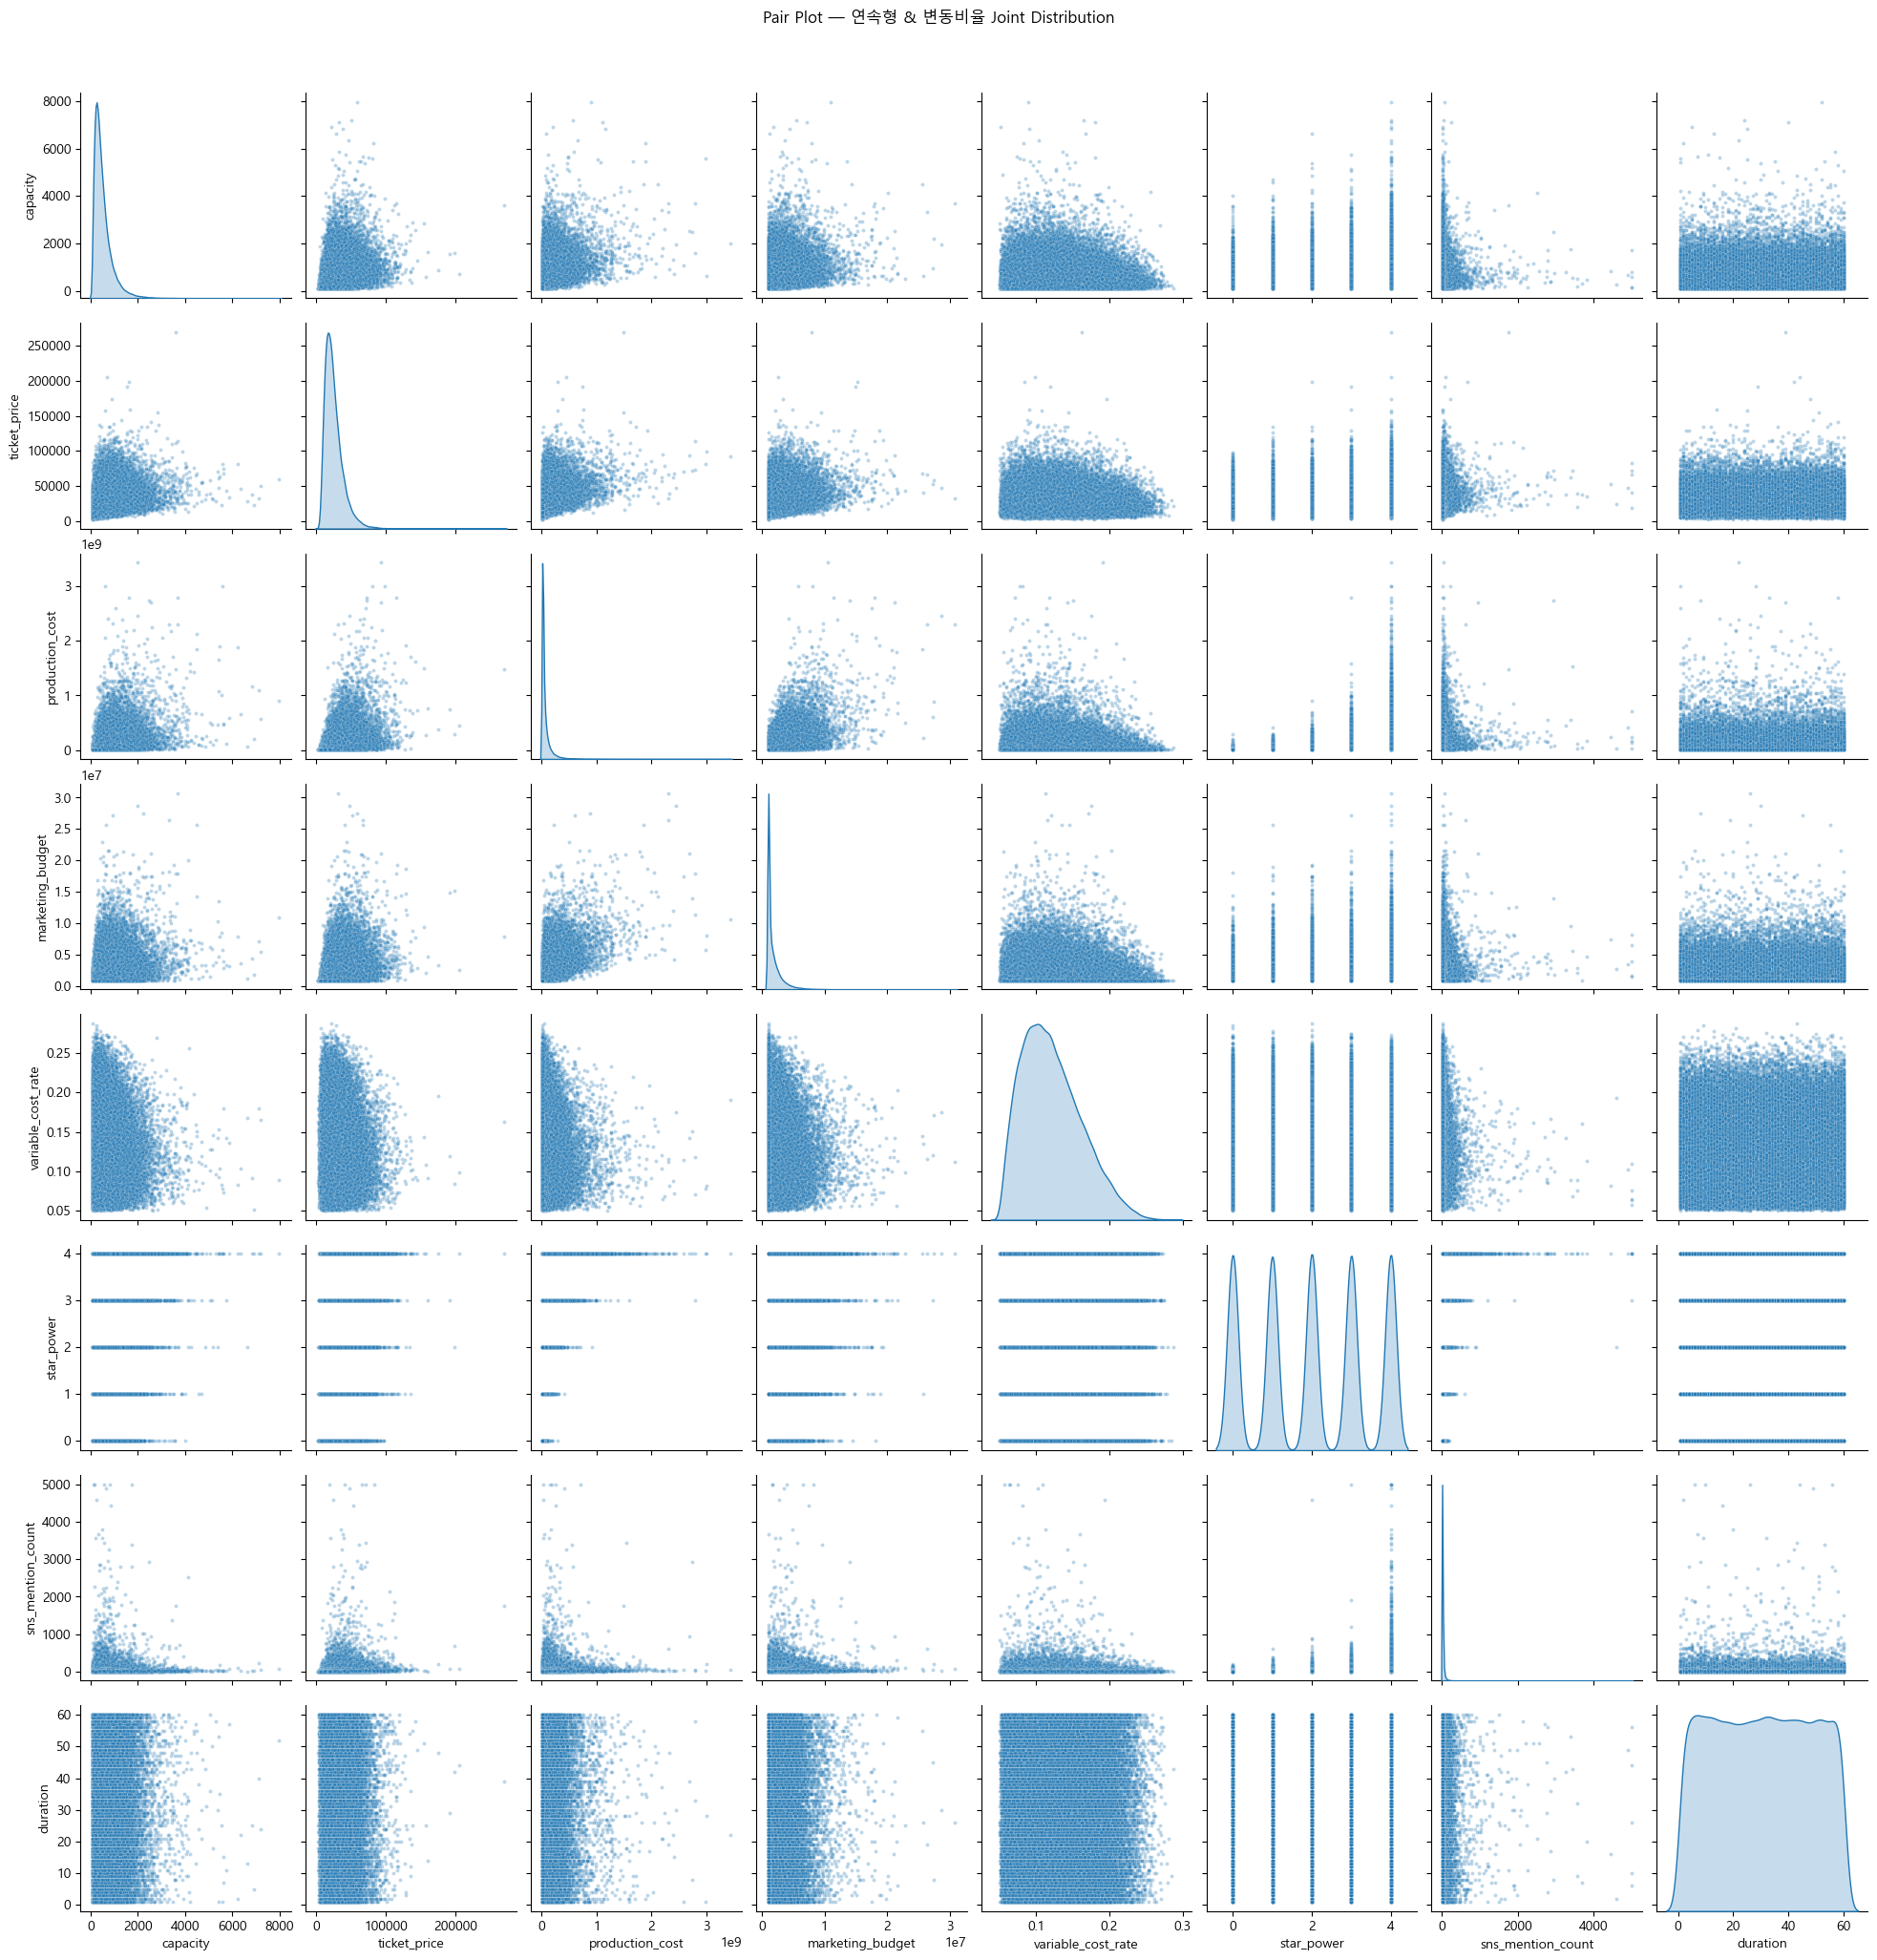


[PairPlot 해석 가이드]
● star_power ↗︎ production_cost   : 우상향 지수 패턴 → 지수효과(0.5 log mean)가 잘 적용됐는지 확인
● production_cost ↔︎ marketing_budget (ρ≈0.8) : 굵은 대각선 점군?  → Σ 행렬 값과 시각 비교
● variable_cost_rate ←→ 비용·규모 변수 : 음/양 상관 설계값 대비 과·부족 여부 체크
● capacity ↔︎ ticket_price       : 완만한 양의 상관 (대형 공연장 = 고가격 장르)
클러스터·수평선·수직선 등 ‘벽’ 모양이 보이면 → 클리핑·이산값 과다 여부 점검



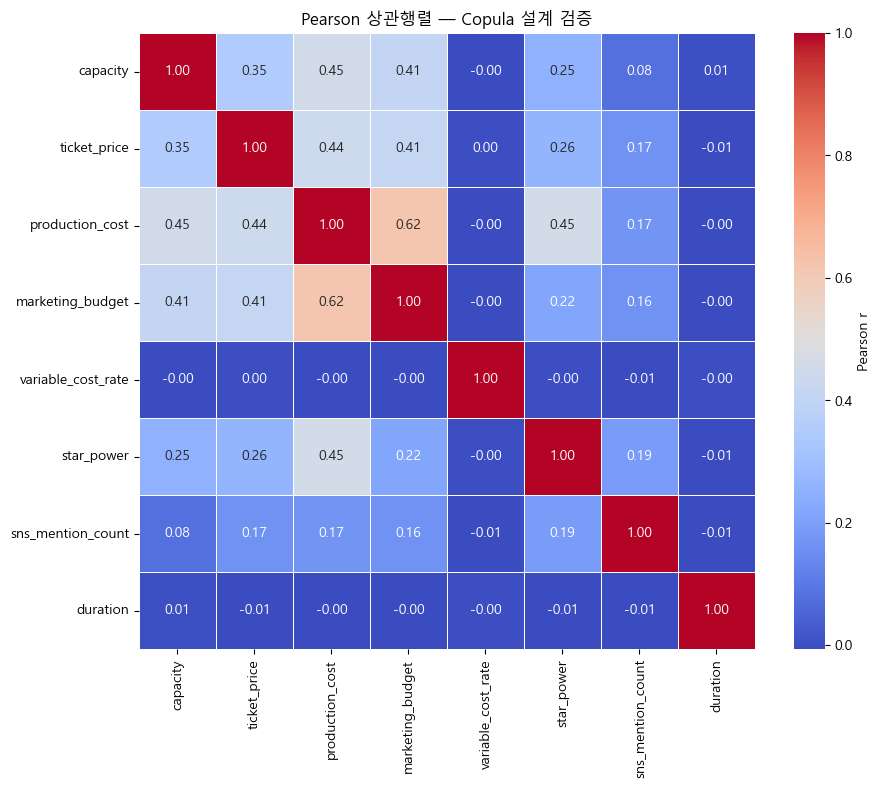

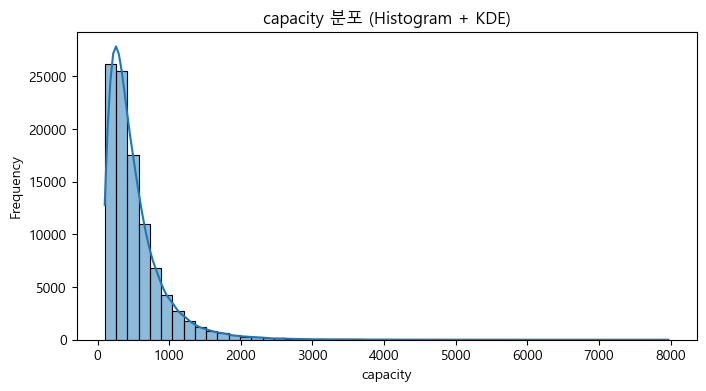

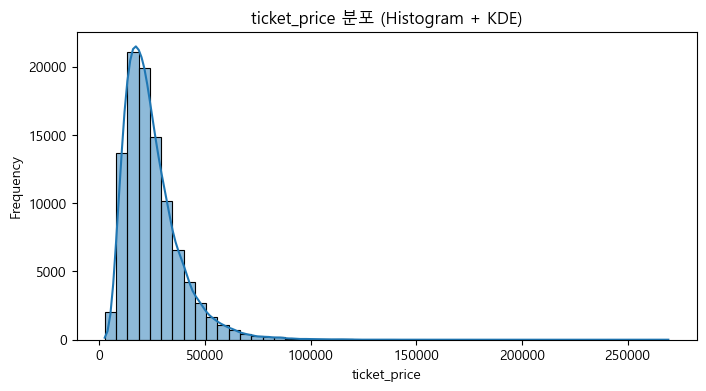

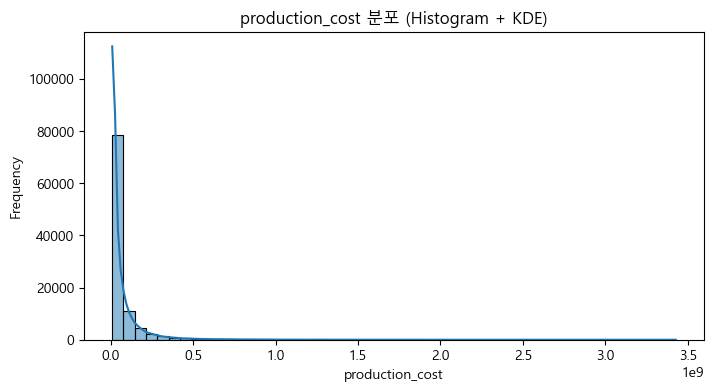

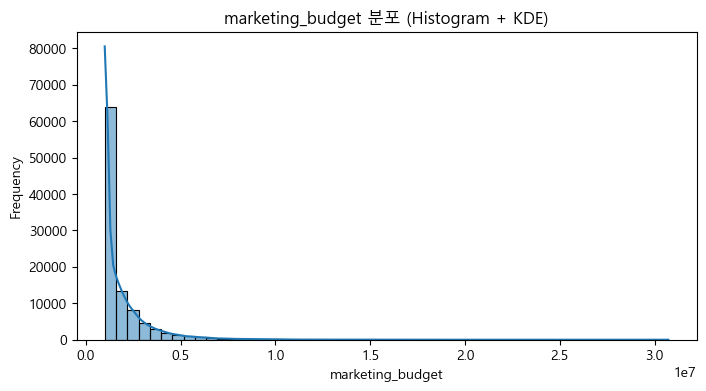

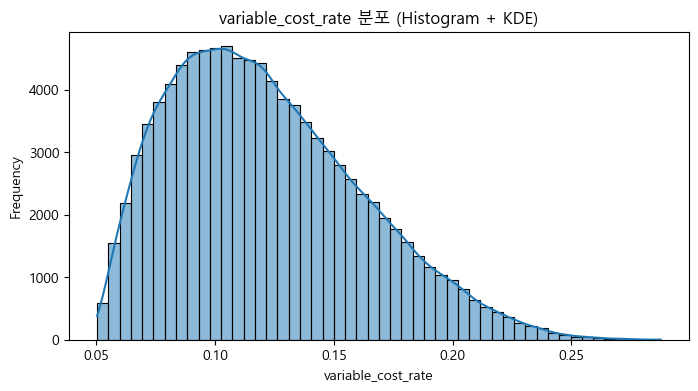

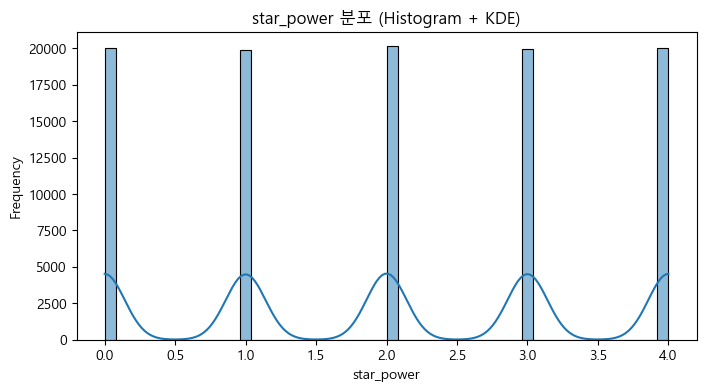

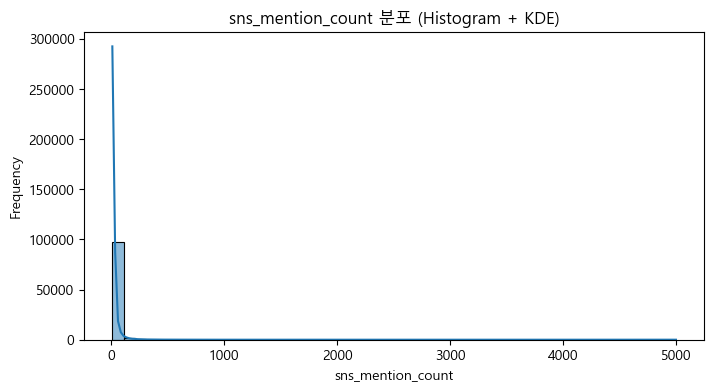

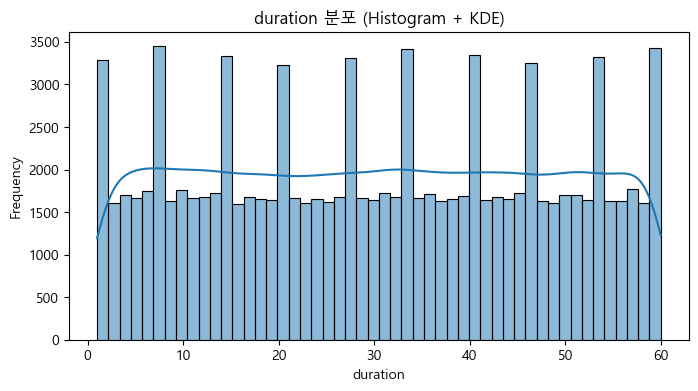

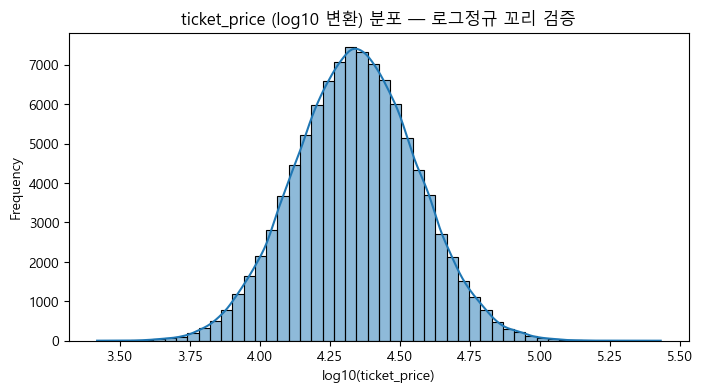

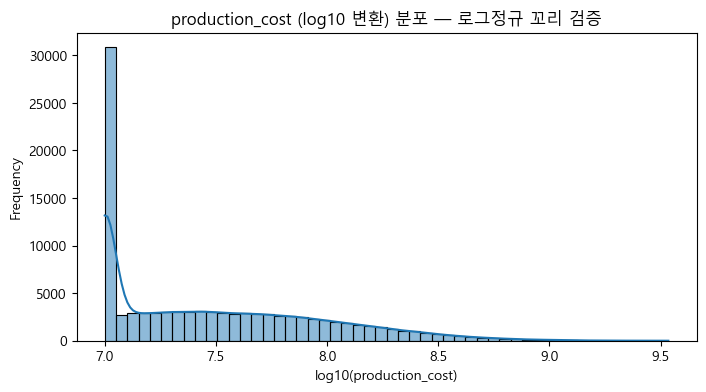

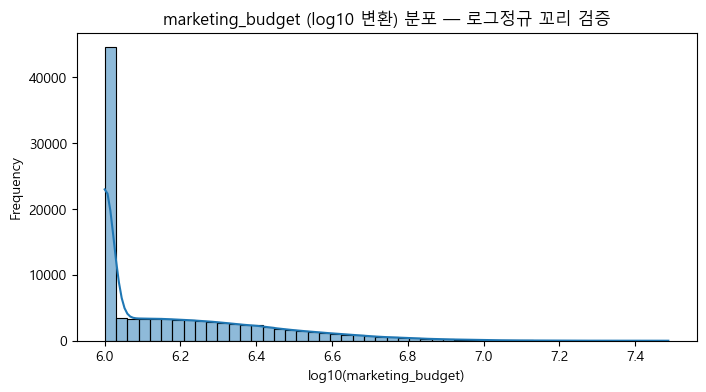

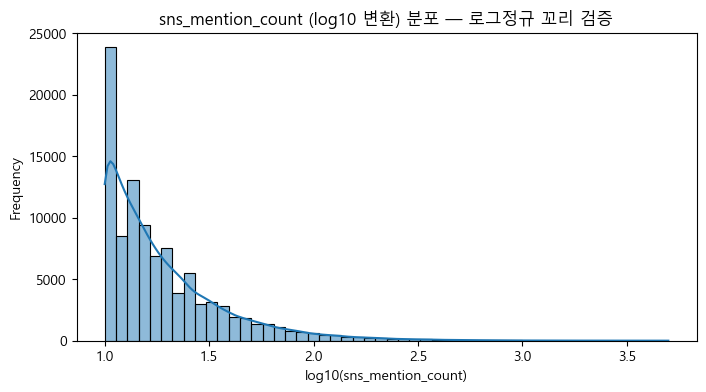

c:\Users\USER\anaconda3\envs\ds_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


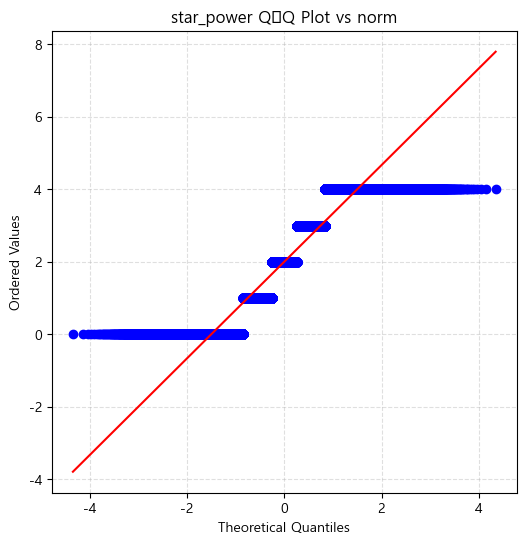

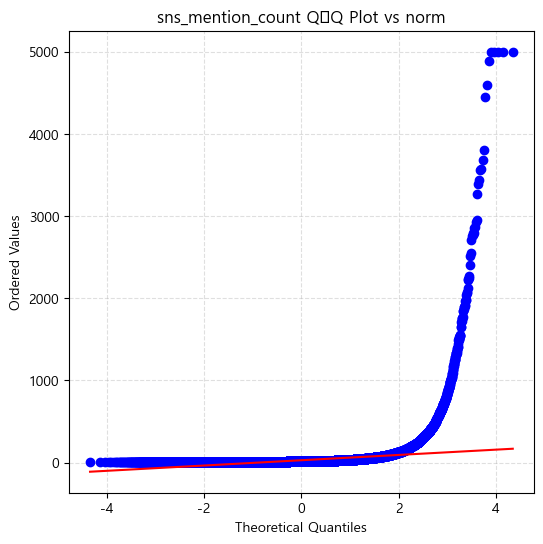

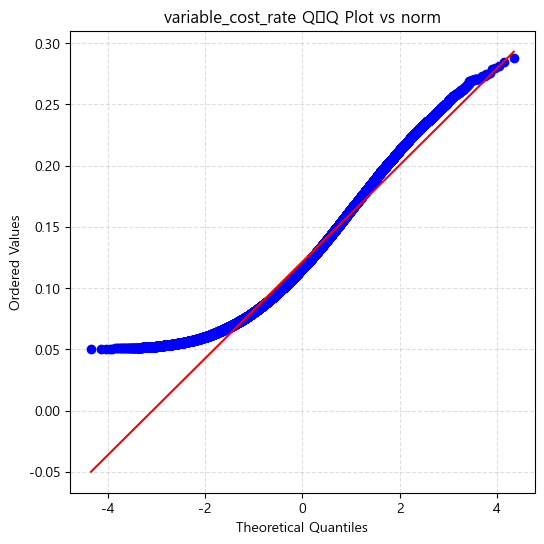


────────────────────────────────────────────────────────────
◎ 검증 체크리스트 (결과 해석 가이드)
1) 히트맵 r 값 · PairPlot 기울기 → 설계 Σ ±0.05 이내?  벗어나면 Σ or 클리핑 재조정
2) log10 히스토그램 → 대칭 + 가우시안?  로그정규 파라미터(μ,σ) OK
3) variable_cost_rate 히스토그램 → 5 % 부근 최고, 30 %로 급격 감소?  Beta(2,5) 스케일 OK
4) Q‑Q Plot 극단부 이탈 → 클리핑 범위·σ 값이 지나치게 낮거나 높은지 검토
────────────────────────────────────────────────────────────
검증 스크립트 종료 — 이상 패턴 발견 시:
  ↳ Copula Σ 행렬 / 로그정규 μ·σ / 클리핑 상하한 값을 조정 후 재실행



In [13]:
"""
검증 & 시각화 스크립트 (주석 강화 버전)
────────────────────────────────────────────────────────────
● 목적
  ①  Copula 로 만든 공동 분포(상관 구조)가 설계값(Σ 행렬)과 일치하는가?
  ②  각 변수의 주변(마진) 분포가 ‘문헌 기반 파라미터’ 그대로 나왔는가?
  ③  변동비율(variable_cost_rate)을 포함한 재무 · 흥행 변수 간 의존성 직관 확인
  ④  이상/편차 발견 시 어떤 파라미터를 조정해야 하는지 즉시 알 수 있게 가이드
────────────────────────────────────────────────────────────
참조 문헌
  • Broadway League Annual Report 2024  : 제작비·마케팅비 상관, 공연 기간
  • The Hustle 2019 (브로드웨이)       : 제작비 분포, 변동비율(5~30 %) 업계 범위
  • KOPIS 2024 (한국 공연시장)         : 장르·지역·티켓 가격 분포
"""

# ──────────────────────────────────────────────────────────
# 0. 라이브러리 로드 & 폰트 설정
# ──────────────────────────────────────────────────────────
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
import matplotlib as mpl

mpl.rc('font', family='Malgun Gothic')   # Windows 예시. Mac → AppleGothic, Linux → NanumGothic
mpl.rc('axes', unicode_minus=False)      # − 기호 깨짐 방지

# ──────────────────────────────────────────────────────────
# 1. 데이터 로드  + 스키마 1차 확인
# ──────────────────────────────────────────────────────────
df = pd.read_csv("performance_tb.csv",
                 parse_dates=["start_date", "end_date"])  # 날짜형 파싱

print("◈ 데이터 샘플(5행) — 모든 컬럼·dtype 확인")
print(df.head(), "\n")

# ──────────────────────────────────────────────────────────
# 2. Pair Plot  — Joint Distribution Quick Scan
# ──────────────────────────────────────────────────────────
# • 산점도 행렬로 모든 연속형 변수의 ‘형태·기울기·클러스터’를 즉시 파악
# • 대각선 KDE → 각 변수의 주변 분포(한눈에)
continuous_vars = [
    "capacity", "ticket_price",
    "production_cost", "marketing_budget",
    "variable_cost_rate",       # ★ 새로 포함된 변동비율
    "star_power", "sns_mention_count",
    "duration"
]

print("▶ PairPlot 생성 (수만 점 → 약간 시간 소요)…")
sns.pairplot(
    df[continuous_vars],
    diag_kind="kde",        # 대각선 : Kernel Density  (히스토그램보다滑らか)
    plot_kws={"alpha":0.3,  # 점 투명도 — 겹침 완화
              "s":8}        # 점 크기 — 100k 샘플 최적
)
plt.suptitle("Pair Plot — 연속형 & 변동비율 Joint Distribution", y=1.03)
plt.show()

# ── 해석 가이드(콘솔) ───────────────────────────────
print("""
[PairPlot 해석 가이드]
● star_power ↗︎ production_cost   : 우상향 지수 패턴 → 지수효과(0.5 log mean)가 잘 적용됐는지 확인
● production_cost ↔︎ marketing_budget (ρ≈0.8) : 굵은 대각선 점군?  → Σ 행렬 값과 시각 비교
● variable_cost_rate ←→ 비용·규모 변수 : 음/양 상관 설계값 대비 과·부족 여부 체크
● capacity ↔︎ ticket_price       : 완만한 양의 상관 (대형 공연장 = 고가격 장르)
클러스터·수평선·수직선 등 ‘벽’ 모양이 보이면 → 클리핑·이산값 과다 여부 점검
""")

# ──────────────────────────────────────────────────────────
# 3. Pearson 상관행렬 히트맵
# ──────────────────────────────────────────────────────────
# • 시뮬레이션된 r 값이 설계 Σ 행렬(예: prod vs mkt = 0.8) 과 ±0.05 내인지 체크
plt.figure(figsize=(10,8))
corr = df[continuous_vars].corr(method="pearson")
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm",
            linewidths=.5, square=True,
            cbar_kws={"label":"Pearson r"})
plt.title("Pearson 상관행렬 — Copula 설계 검증")
plt.show()

# ──────────────────────────────────────────────────────────
# 4. Histogram + KDE  — 마진 분포 형태 검증
# ──────────────────────────────────────────────────────────
# • 각 변수 단독 분포를 눈으로 확인 (꼬리·최빈 구간 등)
for var in continuous_vars:
    plt.figure(figsize=(8,4))
    sns.histplot(df[var], kde=True, bins=50)
    plt.title(f"{var} 분포 (Histogram + KDE)")
    plt.xlabel(var); plt.ylabel("Frequency")
    plt.show()

# ▣ 로그정규 대상 변수는 log10 히스토그램 추가 (꼬리 대칭 여부 확인)
log_vars = ["ticket_price", "production_cost", "marketing_budget",
            "sns_mention_count"]
for v in log_vars:
    plt.figure(figsize=(8,4))
    sns.histplot(
        np.log10(df[v].replace(0, np.nan).dropna()),
        kde=True, bins=50
    )
    plt.title(f"{v} (log10 변환) 분포 — 로그정규 꼬리 검증")
    plt.xlabel(f"log10({v})"); plt.ylabel("Frequency")
    plt.show()

# ──────────────────────────────────────────────────────────
# 5. Q‑Q Plot  — 정규성 / 비대칭성 상세 검증
# ──────────────────────────────────────────────────────────
# • 정규분포와 직선 ⇒ 대칭(정규) / 굽음 ⇒ 치우침 (로그정규·파레토·Beta)
def qq_plot(series, var, dist=stats.norm):
    plt.figure(figsize=(6,6))
    stats.probplot(series, dist=dist, plot=plt)  # SciPy probplot
    plt.title(f"{var} Q‑Q Plot vs {dist.name}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Ordered Values")
    plt.grid(ls="--", alpha=.4)
    plt.show()

# 대표 변수 3개 검사
qq_plot(df["star_power"],         "star_power")          # → 계단형(이산) 예상
qq_plot(df["sns_mention_count"],  "sns_mention_count")   # → 오른쪽 위 치솟음(파레토)
qq_plot(df["variable_cost_rate"], "variable_cost_rate")  # → Beta J‑shape : 중심부 아래쪽 휨

print("""
────────────────────────────────────────────────────────────
◎ 검증 체크리스트 (결과 해석 가이드)
1) 히트맵 r 값 · PairPlot 기울기 → 설계 Σ ±0.05 이내?  벗어나면 Σ or 클리핑 재조정
2) log10 히스토그램 → 대칭 + 가우시안?  로그정규 파라미터(μ,σ) OK
3) variable_cost_rate 히스토그램 → 5 % 부근 최고, 30 %로 급격 감소?  Beta(2,5) 스케일 OK
4) Q‑Q Plot 극단부 이탈 → 클리핑 범위·σ 값이 지나치게 낮거나 높은지 검토
────────────────────────────────────────────────────────────
검증 스크립트 종료 — 이상 패턴 발견 시:
  ↳ Copula Σ 행렬 / 로그정규 μ·σ / 클리핑 상하한 값을 조정 후 재실행
""")
